In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
target_loc = 3
target_scale = 0.8

In [5]:
eps = 1e-10

In [6]:
def generator(noise_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(noise_in, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, these_vars

In [7]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [8]:
def make_EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    # generator output
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    
    # target
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [22]:
def save_plots(file_path):
    # compare initial distributions
    target_test = np.random.normal(loc = target_loc, scale = target_scale, size = (10000, 1))
    noise_test = np.random.uniform(low = 0.0, high = 1.0, size = (10000, 20))
    gen_output_test = sess.run(gen_out,  feed_dict = {noise_in: noise_test})
    
    plt.clf()
    plt.hist([np.squeeze(target_test), np.squeeze(gen_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
    plt.xlim([-1, 5])
    plt.ylim([0, 3])
    plt.legend()
    #plt.savefig(file_path)

In [10]:
noise_in = tf.placeholder(tf.float32, [None, 20], name = 'noise_in')
target_in = tf.placeholder(tf.float32, [None, 1], name = 'target_in')

In [11]:
gen_out, gen_vars = generator(noise_in, "gen")

In [12]:
EM_lossval, EM_vars, EM_dist = make_EM_loss(gen_out, target_in, "EM_loss_obj")

In [13]:
train_EM = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.0, beta2 = 0.5).minimize(EM_lossval, var_list = EM_vars)

In [14]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(EM_dist, var_list = gen_vars)

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
init_critic = tf.variables_initializer(EM_vars)

In [17]:
sess.run(init_critic)

In [18]:
# prepare noise
for i in range(200):
    target = np.random.normal(loc = target_loc, scale = target_scale, size = (1000, 1))
    noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
    sess.run(train_EM, feed_dict = {noise_in: noise, target_in: target})

    EM_dist_val = sess.run(EM_dist, feed_dict = {noise_in: noise, target_in: target})
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [0.7862968]
EM_dist = [1.1461098]
EM_dist = [1.5194851]
EM_dist = [1.961839]
EM_dist = [2.3510592]
EM_dist = [2.80776]
EM_dist = [3.0867898]
EM_dist = [3.2556067]
EM_dist = [3.3038454]
EM_dist = [3.306084]
EM_dist = [3.3657734]
EM_dist = [3.1890154]
EM_dist = [3.6272104]
EM_dist = [2.9281626]
EM_dist = [3.5557027]
EM_dist = [3.0213337]
EM_dist = [3.5503652]
EM_dist = [3.0065007]
EM_dist = [3.563335]
EM_dist = [2.99751]
EM_dist = [3.6158352]
EM_dist = [3.0502827]
EM_dist = [3.5994413]
EM_dist = [3.0204787]
EM_dist = [3.543614]
EM_dist = [3.0177054]
EM_dist = [3.5858884]
EM_dist = [3.0599482]
EM_dist = [3.561429]
EM_dist = [3.0412028]
EM_dist = [3.5074186]
EM_dist = [3.0529974]
EM_dist = [3.5561814]
EM_dist = [3.0081954]
EM_dist = [3.5132136]
EM_dist = [3.0927157]
EM_dist = [3.5584726]
EM_dist = [2.9867392]
EM_dist = [3.5341086]
EM_dist = [3.0398378]
EM_dist = [3.5050344]
EM_dist = [3.0208282]
EM_dist = [3.5995083]
EM_dist = [2.9937396]
EM_dist = [3.592369]
EM_dist = [3.1075435

In [19]:
# compare initial distributions
target_test = np.random.normal(loc = target_loc, scale = target_scale, size = (1000, 1))
noise_test = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
gen_output_test = sess.run(gen_out,  feed_dict = {noise_in: noise_test})

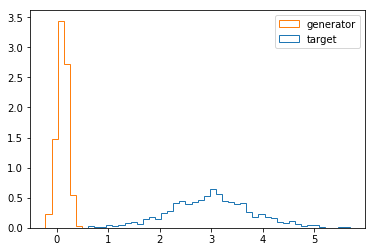

In [20]:
plt.hist([np.squeeze(target_test), np.squeeze(gen_output_test)], label = ['target', 'generator'], histtype = 'step', density = True, bins = 50)
plt.legend()
plt.show()

In [27]:
for i in range(0, 800):
    # prepare noise
    for j in range(200):
        target = np.random.normal(loc = target_loc, scale = target_scale, size = (1000, 1))
        noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
        sess.run(train_EM, feed_dict = {noise_in: noise, target_in: target})
    
    target = np.random.normal(loc = target_loc, scale = target_scale, size = (1000, 1))
    noise = np.random.uniform(low = 0.0, high = 1.0, size = (1000, 20))
    sess.run(train_gen, feed_dict = {noise_in: noise, target_in: target})
    EM_dist_val = sess.run(EM_dist, feed_dict = {noise_in: noise, target_in: target})
    critic_loss = sess.run(EM_lossval, feed_dict = {noise_in: noise, target_in: target})
    
    print("W = {}".format(EM_dist_val))
    print("critic loss = {}".format(critic_loss))
    
    #save_plots("WGAN_training/epoch_" + str(i).zfill(5) + ".png")

W = [0.20985079]
critic loss = -0.20843560993671417
W = [0.17278099]
critic loss = -0.17039068043231964
W = [0.21560001]
critic loss = -0.21365861594676971
W = [0.23274946]
critic loss = -0.23176927864551544
W = [0.15929604]
critic loss = -0.15800470113754272
W = [0.19650602]
critic loss = -0.19574770331382751
W = [0.21431828]
critic loss = -0.20379489660263062
W = [0.17876482]
critic loss = -0.17015188932418823
W = [0.19500065]
critic loss = -0.18603713810443878
W = [0.16813087]
critic loss = -0.15895363688468933
W = [0.14949036]
critic loss = -0.1415783166885376
W = [0.20400333]
critic loss = -0.19407868385314941
W = [0.20033884]
critic loss = -0.19419841468334198
W = [0.22081089]
critic loss = -0.2122649848461151
W = [0.2344203]
critic loss = -0.22523164749145508
W = [0.1694293]
critic loss = -0.16164924204349518
W = [0.2031765]
critic loss = -0.19795243442058563
W = [0.16229153]
critic loss = -0.15230737626552582
W = [0.18775034]
critic loss = -0.17894986271858215
W = [0.20972347]


KeyboardInterrupt: 

In [28]:
save_plots("local")

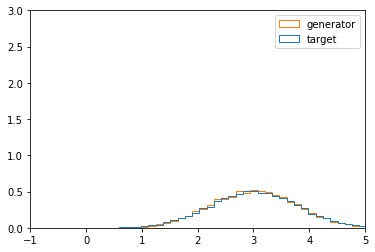

In [29]:
plt.show()